## Code to analyze MRIQC output


In [2]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [8]:
dataset = "qpn"
current_release = "Oct_2024"
mriqc_version = "23.1.0"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# mri_info
mri_sessions_csv = f"{tabular_dir}/mri_info/mri_sessions.csv"

# collated qc outputs
mriqc_dir = f"{dataset_dir}/derivatives/mriqc/{mriqc_version}/IDP/{session}/"

# save dirs
save_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"{dataset_dir}/results/{session}/anat/figs/"

# Create dirs for results if they don't exist
Path(f"{save_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Colormaps

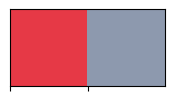

In [9]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### manifest

In [22]:
manifest_cols = ["participant_id", "visit", "session"]
nipoppy_df = pd.read_csv(manifest_csv)
nipoppy_df = nipoppy_df[manifest_cols] 
nipoppy_participants = nipoppy_df["participant_id"].unique()
n_nipoppy_participants = len(nipoppy_participants)
print(f"nipoppy participants: {n_nipoppy_participants}")
nipoppy_df.head()

nipoppy participants: 306


,participant_id,visit,session
0,MNI0215,MRI_v1,ses-01
1,PD01145,MRI_v1,ses-01
2,MNI0313,MRI_v1,ses-01
3,MNI0476,MRI_v1,ses-01
4,PD01214,MRI_v1,ses-01


### Diagnosis info
- as confirmed later by the clinicians

In [23]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"][["participant_id", "diagnosis_group_for_analysis"]]

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

PD + control: 271
Control: 69
PD: 202


,participant_id,diagnosis_group_for_analysis
0,MNI0028,unknown
1,MNI0056,PD
2,MNI0058,PD
3,MNI0068,PD
4,MNI0079,PD


### Read mriqc output

In [48]:
anat_csv = f"{mriqc_dir}/anat_IQM.csv"
func_csv = f"{mriqc_dir}/func_IQM.csv"

anat_df = pd.read_csv(anat_csv)
func_df = pd.read_csv(func_csv)

func_df.head()


,participant_id,session_id,tsnr,snr,tsnr.1,gcor,efc,fber,aor,aqi,...,summary_fg_p95,summary_fg_stdv,fd_mean,fd_num,fd_perc,gsr_x,gsr_y,dvars_nstd,dvars_std,dvars_vstd
0,MNI0028,1,78.928023,4.582493,78.928023,0.014892,0.476848,7523.095215,0.001593,0.005586,...,502.448029,78.510714,0.119464,12,4.800000,0.004915,0.018147,15.343684,1.092196,0.993816
1,MNI0058,1,59.550859,3.443100,59.550859,0.022965,0.379183,5006.864258,0.001625,0.003248,...,546.160034,104.971377,0.158522,51,20.400000,-0.027311,0.049558,22.249279,1.115735,1.013731
2,MNI0068,1,80.770002,4.544021,80.770002,0.036762,0.450321,5950.910645,0.001001,0.004871,...,516.502014,81.540984,0.115351,35,14.056225,0.002944,0.009668,20.997492,1.254809,1.002452
3,MNI0079,1,66.394148,4.739866,66.394148,0.009193,0.452169,7679.188965,0.000814,0.010178,...,580.660034,88.075792,0.229473,121,48.400000,-0.005594,0.015205,18.446369,1.068431,0.965346
4,MNI0103,1,56.639128,4.197841,56.639128,0.031287,0.481004,7993.544434,0.002270,0.008394,...,668.976013,108.108400,0.297866,166,66.400000,0.007654,0.019429,31.618724,1.213297,0.994211


### Plot anat IQMs

n_participants: 269
participants_per_group: group
PD         200
control     69
Name: participant_id, dtype: int64


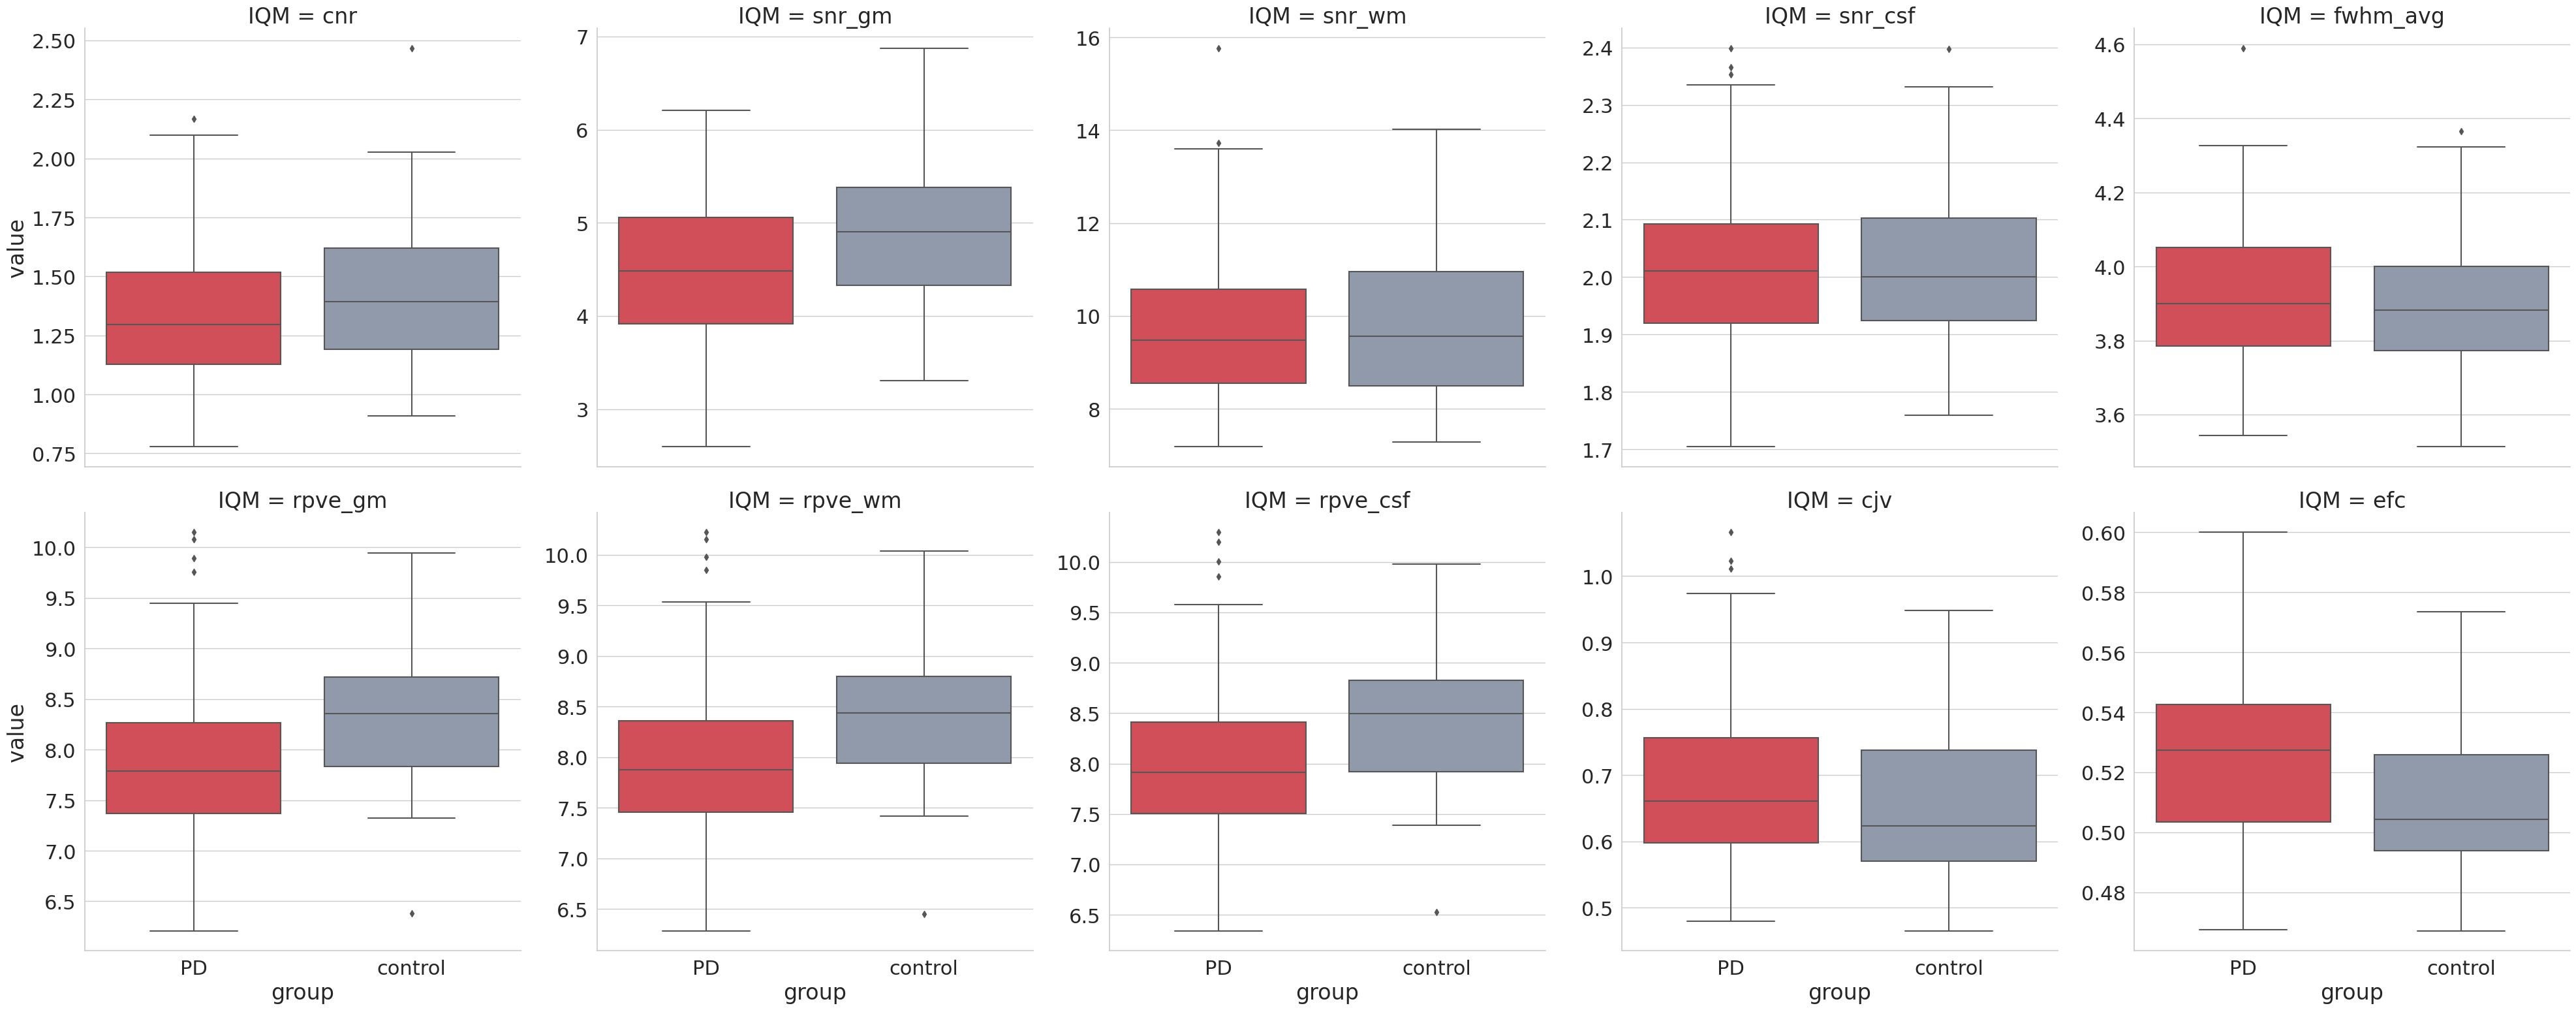

In [50]:
save_fig = False

IQM_cols = ["cnr", "snr_gm",  "snr_wm", "snr_csf",	"fwhm_avg", "rpve_gm", "rpve_wm", "rpve_csf", "cjv", "efc"]

demo_cols = ["participant_id", "session_id", "diagnosis_group_for_analysis"]
plot_groups = ["control","PD"]

anat_dx_df = pd.merge(anat_df, dx_df, on="participant_id")[IQM_cols + demo_cols]
anat_dx_df = anat_dx_df[anat_dx_df["diagnosis_group_for_analysis"].isin(plot_groups)]

anat_df_melt = anat_dx_df.melt(
    id_vars=demo_cols, 
    var_name="IQM", 
    value_name="value")

plot_df = anat_df_melt.copy()
plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")

participants_per_group = plot_df.groupby(["group"])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")


sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="group",y="value", col="IQM", col_wrap=5, sharey=False,
                    kind="box",palette=palette, data=plot_df, aspect=1, height=8)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    print(f"Saving figure to {figs_dir}")
    g.savefig(f"{figs_dir}/NM.png")

### Plot func IQMs

n_participants: 269
participants_per_group: group
PD         200
control     69
Name: participant_id, dtype: int64


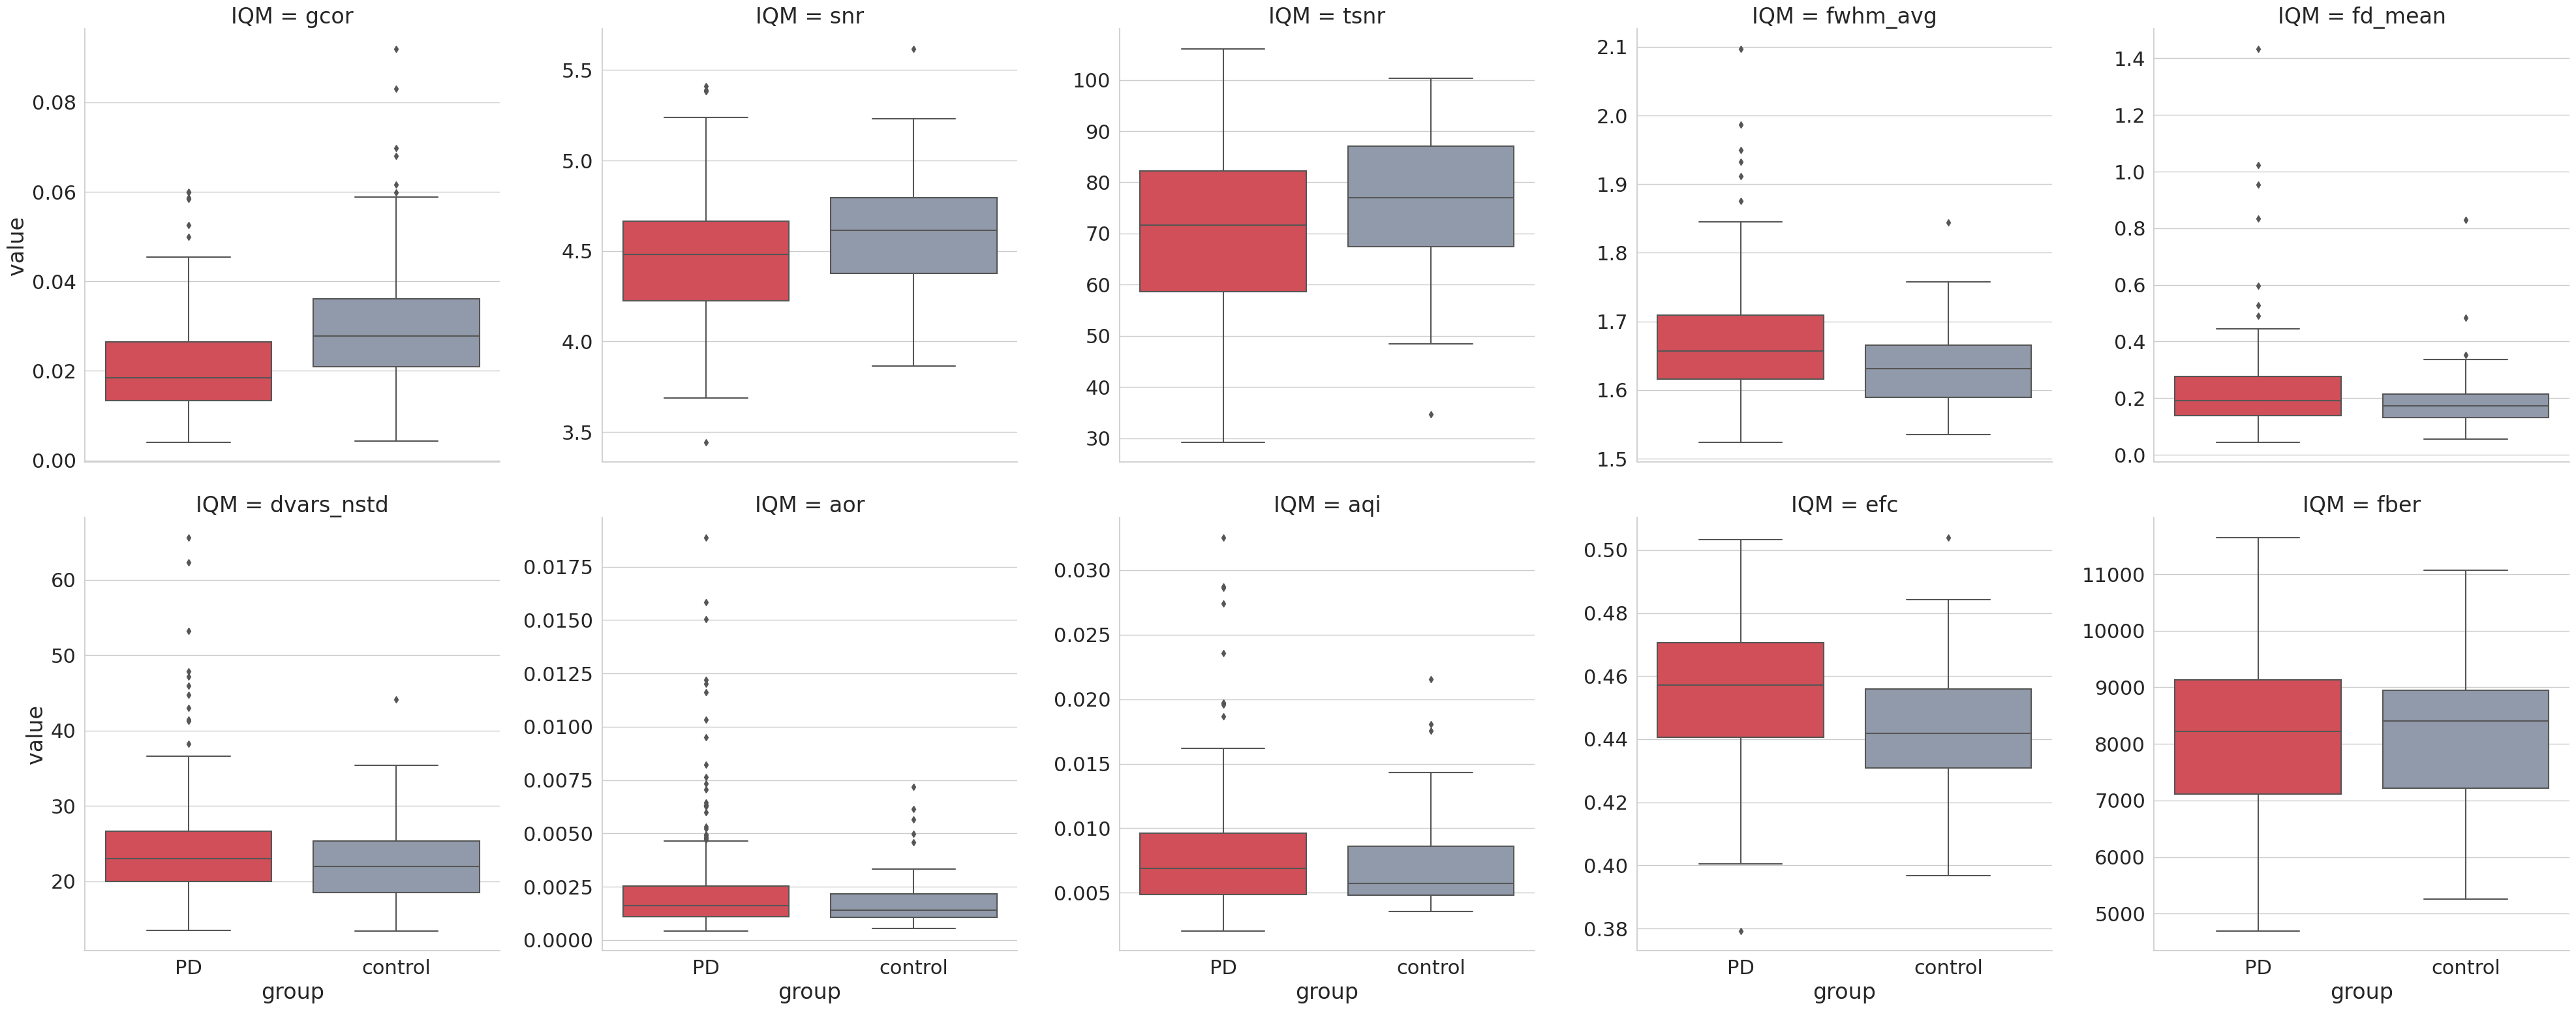

In [51]:
save_fig = False

IQM_cols = ["gcor", "snr", "tsnr", "fwhm_avg", "fd_mean", "dvars_nstd", "aor", "aqi", "efc", "fber"]

demo_cols = ["participant_id", "session_id", "diagnosis_group_for_analysis"]
plot_groups = ["control","PD"]

func_dx_df = pd.merge(func_df, dx_df, on="participant_id")[IQM_cols + demo_cols]
func_dx_df = func_dx_df[func_dx_df["diagnosis_group_for_analysis"].isin(plot_groups)]

func_df_melt = func_dx_df.melt(
    id_vars=demo_cols, 
    var_name="IQM", 
    value_name="value")

plot_df = func_df_melt.copy()
plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")

participants_per_group = plot_df.groupby(["group"])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")


sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="group",y="value", col="IQM", col_wrap=5, sharey=False,
                    kind="box",palette=palette, data=plot_df, aspect=1, height=8)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    print(f"Saving figure to {figs_dir}")
    g.savefig(f"{figs_dir}/NM.png")